In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import argparse
import numpy as np

In [2]:
parser = argparse.ArgumentParser(description='')
parser.add_argument('--file', '-f', type=list, help='Input file path')
files = ['pmt_measurements_luminous.csv']
options = ['-f', files]
args = parser.parse_args(args=options)

In [33]:
ylimits = {'gain':[1e5,1e8],
           'chisqr':[None, None],
           'pv_r':[0.,5.],
           'sigma':[0.,30.],
           'pe_res':[0.,150.],
           'N_PE':[0.,250.]
          }
    

key N_PE
value Number of PE
PN23051100
key N_PE
[196.6517755344813, 198.8495169408605, 189.52328404042655, 167.23111400589357, 167.06799522506904]
[26.483366820949257, 26.858500514009062, 26.4375320241517, 24.82797985420528, 26.860858390830266]


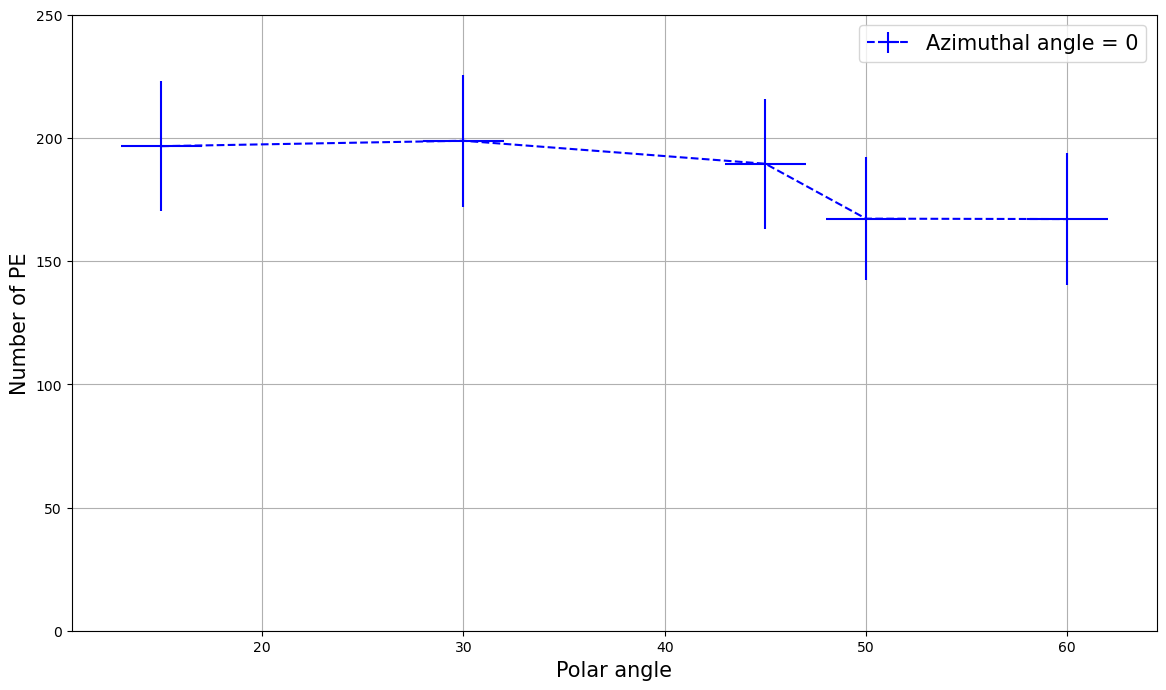

In [45]:

brand_dict = {"ham": "Hamamatsu", "nnvt" : "NNVT", "NNVT":"NNVT", "HAM": "Hamamatsu"}
markers = ['o', 's', 'v', '^']
colors = ("b", "orange", "g", "r", "c", "m", "y", "k")
fname = args.file[0]

fdt = fname.split("_")[0]

df = pd.read_csv(fname)

# Assumes standarde file naming format
def get_v_from_fname(row):
    base = Path(row["fname"]).stem

    # Get brand model and voltage from filename
    brand, model, voltage, angle = base.split("_")
    brand = brand_dict[brand]
    # Get rid of "v" in string if there
    if voltage[-1] == "V":
        voltage = voltage[:-1]
    
    azAngle = angle[2:4]
    polAngle = angle[7:9]
    return brand, model, float(voltage), int(azAngle), int(polAngle)

# Expand here means when apply returns multiple values, they get assigned to
# each given new column
df[["brand","model","v", "azAngle", "polAngle"]] = df.apply(get_v_from_fname, axis="columns", result_type="expand")

# Sort so V is in order
df = df.sort_values(["azAngle","polAngle"], ascending=True)
df = df.set_index("azAngle")

# Group by the model and plot each value
df_group = df.groupby("model")

'''
# Get the NNVT measurements if given
if len(args.file) > 1:
    nnvt_fname = args.file[1]
    nnvt_df = pd.read_csv(nnvt_fname)

    # Only get the same models for direct comparison
    nnvt_df = pd.merge(nnvt_df, df["model"].drop_duplicates())
    # Add clarification in label
    nnvt_df["model"] = nnvt_df["model"].apply(lambda x: x + " (NNVT)")
    nnvt_df = nnvt_df.sort_values(["v","model"], ascending=True)
    nnvt_df = nnvt_df.set_index("v")

    # Given in units of 1e7
    nnvt_df["gain"] *= 1e7
    nnvt_df_group = nnvt_df.groupby("model")
'''
    
plot_cols = {
    #"gain" : "Gain", 
    #"chisqr" : r"$\chi^2$", 
    #"pv_r" : "Peak-Valley Ratio", 
    #"sigma" : r"$\sigma$", 
    #"pe_res" : "PE Resolution %"
    "N_PE" : "Number of PE"
}

# List of values to be log-plotted
logs = [
    'gain',
    "chisqr"
]

# Marker size is a bit small by default
msize = 15

fontsize = 15

for key,value in plot_cols.items():
    print('key', key)
    print('value', value)
    fig, ax = plt.subplots()
    
    # Cycle through grouped df plotting each PMT
    idx=0
    for pmt,df_pmt in df_group:
        print(pmt)
        if type(df_pmt[key].values[0]) != str:
            val =  [float(str_v) for str_v in df_pmt[key].values]
            err = [float(str_v) for str_v in df_pmt['sigma[NPE]'].values]
        #elif '(' in df_pmt[key].values:
        else:
            val = [ str_v.replace('(', '').replace(')','').split(',')[0] for str_v in df_pmt[key].values ]
            err = [ str_v.replace('(', '').replace(')','').split(',')[0] for str_v in df_pmt['sigma[NPE]'].values ]
            val = [float(i) for i in val]
            err = [float(i) for i in err]
        
        print('key',key)
        print(val)
        print(err)
        #print('max', np.max(val))
        
        if 'KM' in pmt:
            marker = markers[0]
            linestyle = '-'
        elif 'PN' in pmt:
            marker = markers[1]
            linestyle = ':'
            if 'PN23' in pmt:
                marker = markers[2]
                linestyle = '--'
            if '(NNVT)' in pmt:
                marker = markers[3]
                linestyle = ':'
        color=colors[idx]
        format_str = "{color}{marker}-".format(color=color, marker=marker)
        #ax.plot(df_pmt[key], format_str, label=pmt)
        #ax.plot(df_pmt['polAngle'].values, val, label='Azimuthal angle = %.0f'%df_pmt.index.values[0].astype(float), color=color, linestyle=linestyle)
        if len(err)>0:
            if key=='N_PE':
                ax.errorbar(df_pmt['polAngle'].values, y=val, yerr = err, xerr = 2, label='Azimuthal angle = %.0f'%df_pmt.index.values[0].astype(float), color=color, linestyle=linestyle)

        idx+=1
    
    if len(args.file) > 1:
        try:
            # Same for NNVT df, if it has the info
            #idx = 0
            for pmt,df_pmt in nnvt_df_group:

                if 'KM' in pmt:
                    marker = markers[0]
                    linestyle = '-'
                elif 'PN' in pmt:
                    marker = markers[1]
                    linestyle = ':'
                    if 'PN23' in pmt:
                        marker = markers[2]
                        linestyle = '--'
                    if '(NNVT)' in pmt:
                        marker = markers[3]
                        linestyle = ':'
                color=colors[idx]
                format_str = "{color}{marker}-".format(color=color, marker=marker)
                ax.plot(df_pmt[key], format_str, label=pmt, linestyle=linestyle)
                idx +=1
        except:
            print(f"{key} not in NNVT data. Won't plot")
            
    if key=='gain':
        ax.axhline(5e6, linestyle='-', color='black', label=r'$5\times10^6$ (requirement)')
    if key=='pe_res':
        ax.axhline(50, linestyle='-', color='black', label=r'50% (requirement)')
    if key=='pv_r':
        ax.axhline(2, linestyle='-', color='black', label=r'2 (requirement)')
    


    # Log it if set to
    if key in logs:
        ax.set_yscale("log")

    ax.legend(fontsize=fontsize)
    ax.set_xlabel("Polar angle",fontsize=fontsize)
    ax.set_ylabel(value, fontsize=fontsize)
    ax.set_ylim(ylimits[key])
    ax.grid()

    fig.set_size_inches(14,8)

    fig.savefig(f"{fdt}_{key}.png")

plt.show()
